In [8]:
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import joblib
import json
import numpy as np

sys.path.append('../packages/ClustPy/clustpy')
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from PIL import Image
import requests

# load image
# url = 'http://images.cocodataset.org/val2017/00000003979.jpg'
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("/mnt/data/stephana93dm/storage/projects/thesis/datasets/cards/images/five of diamonds_48.jpg")

In [10]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", device_map="auto")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

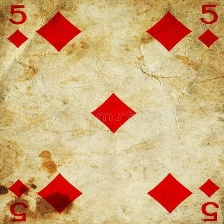

In [92]:
image

In [98]:
prompts = ["Whats the rank?", "Can you tell me the rank of the card shown in the picture? Answer concisely."]
images = [image] * 2

input_prompts = []
for idx, image in enumerate(images):
    for prompt_idx, prompt in enumerate(prompts):
        input_prompts.append({
            "image_idx": idx,
            "prompt_idx": prompt_idx,
            "prompt": f"[INST]<image>\n{prompt}[/INST]",
            "image": image
        })

# inputs = processor(input_prompt, [image] * 10, return_tensors="pt", padding=True).to("cuda:0")
# # autoregressively complete prompt
# output = model.generate(**inputs, max_new_tokens=200, pad_token_id=processor.tokenizer.pad_token_id)

# print(processor.decode(output[0], skip_special_tokens=True).split("[/INST]")[1])

In [94]:
len(input_prompts)

4

In [95]:
class CustomCollator:
    def __init__(self):
        pass

    def __call__(self, batch):
        collated_batch = {}
        key_list = batch[0].keys()
        for key in key_list:
            collated_batch[key] = [item[key] for item in batch]
        return collated_batch

In [99]:
from torch.utils.data import DataLoader

loader = DataLoader(input_prompts, batch_size=16, collate_fn=CustomCollator())

generated_texts = {}

for batch in loader:
    inputs = processor(batch["prompt"], batch["image"], return_tensors="pt", padding=True).to(model.device)

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=200, pad_token_id=processor.tokenizer.pad_token_id)

    for idx, out in enumerate(output):
        generated_text = processor.decode(out, skip_special_tokens=True).split("[/INST]")[1]

        image_idx = batch["image_idx"][idx]
        prompt_idx = batch["prompt_idx"][idx]
        if image_idx not in generated_texts:
            generated_texts[image_idx] = {}
        generated_texts[image_idx][prompt_idx] = generated_text


In [22]:
postprocessed_dict = {}
for image_idx, prompt_dict in generated_texts.items():
    postprocessed_dict[image_idx] = []
    for i in range(len(prompt_dict)):
        postprocessed_dict[image_idx].append(prompt_dict[i])

In [23]:
postprocessed_dict

{0: [' The image you\'ve provided appears to be a playing card, specifically the Ace of Spades. This card is often associated with luck, especially in the context of gambling, as it is considered the most valuable card in a deck of playing cards. The Ace of Spades is also known as the "Ace of Diamonds" in some regions, but it is the same card with a different name. The design on the card includes a spade with a crown on top, which is a common symbol for the Ace of Spades. ',
  ' The image you\'ve provided appears to be a playing card, specifically the Ace of Spades. This card is often associated with luck, especially in the context of gambling, as it is considered the most valuable card in a deck of playing cards. The Ace of Spades is also known as the "Ace of Diamonds" in some regions, but it is the same card with a different name. The design on the card includes a spade with a crown on top, which is a common symbol for the Ace of Spades. ',
  ' The image you\'ve provided appears to b

In [12]:
for out in output:
    print(processor.decode(out, skip_special_tokens=True).split("[/INST]")[1])

 The image shows a playing card with the rank "A" and the suit of spades. 
 Ace 
 The image shows a playing card with the rank "A" and the suit of spades. 
 Ace 
 The image shows a playing card with the rank "A" and the suit of spades. 
 Ace 
 The image shows a playing card with the rank "A" and the suit of spades. 
 Ace 
 The image shows a playing card with the rank "A" and the suit of spades. 
 Ace 


In [7]:
inputs["input_ids"].shape

torch.Size([5, 22])

In [19]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
data_collator = DataCollatorWithPadding(tokenizer)
data = ["input1", "input2"]
dataset = Dataset.from_list([{"input": x} for x in data])
tokenized_prompts = dataset.map(lambda x: tokenizer(x["input"]),
                                remove_columns=dataset.column_names,
                                batched=True)
loader = DataLoader(tokenized_prompts, batch_size=32, shuffle=False, collate_fn=data_collator) 
for batch in loader:
    # Do something here
     outs = model.generate(input_ids=batch["input_ids"].to(0), attention_mask=batch["attention_mask"].to(0),
                temperature=temperature, max_new_tokens=max_new_tokens, do_sample=do_sample, top_p=top_p)
        all_preds.extend([tokenizer.decode(ids, skip_special_tokens=True) for ids in outs])

[INST] 
What is shown in this image? [/INST] The image shows two cats lying on a pink blanket. The cat on the left is curled up in a relaxed position, while the cat on the right is stretched out with its head resting on the blanket. There is a remote control next to the cats, suggesting that this scene might be taking place in a living room or a similar space where people watch television. The cats appear to be sleeping or resting, and the overall atmosphere of the image is cozy and peaceful. 


In [5]:
# out = model(**inputs)

In [5]:
inputs["pixel_values"].shape

torch.Size([1, 5, 3, 336, 336])

In [25]:
def get_image_features(image, model, processor):

    inputs = processor(text=[""], images=[image], return_tensors="pt").to("cuda:0")
    pixel_values = inputs.pixel_values

    batch_size, num_patches, num_channels, height, width = pixel_values.shape
    reshaped_pixel_values = pixel_values.view(batch_size * num_patches, num_channels, height, width)
    image_features = model.vision_tower(reshaped_pixel_values)["pooler_output"].to("cpu")
    image_features = image_features.view(batch_size, num_patches, -1).mean(dim=1)
    return image_features

In [26]:
for i in range(10):
    image_features = get_image_features(image, model, processor)
    print(image_features.shape)


torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])


In [10]:
vision_feature_layer = model.config.vision_feature_layer
selected_image_feature = image_features.hidden_states[vision_feature_layer][:, 0].to("cpu")

In [17]:
image_features.shape

torch.Size([5, 1024])

In [3]:
# Load model directly
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor2 = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14-336")
model2 = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14-336")

In [66]:
model.vision_tower.vision_model.encoder.layers[4].self_attn.k_proj.weight.to("cpu")

tensor([[ 2.0020e-02,  9.6436e-03,  1.7090e-02,  ..., -2.5879e-02,
         -1.5991e-02,  7.6294e-05],
        [ 1.0193e-02, -7.2327e-03,  3.3691e-02,  ...,  9.0332e-03,
         -3.2471e-02,  5.4626e-03],
        [ 9.7046e-03, -2.4170e-02,  5.7373e-03,  ...,  4.1016e-02,
          2.2339e-02, -1.8066e-02],
        ...,
        [-2.5024e-02, -2.5757e-02, -3.2349e-03,  ..., -1.3550e-02,
          3.6011e-03, -5.3406e-04],
        [-5.9891e-04,  2.4658e-02, -3.0518e-02,  ..., -1.3000e-02,
          6.1417e-04, -1.9409e-02],
        [ 1.7334e-02, -2.3804e-02,  1.2390e-02,  ..., -4.5166e-03,
         -4.2236e-02,  9.2773e-03]], grad_fn=<ToCopyBackward0>)

In [67]:
model2.vision_model.encoder.layers[4].self_attn.k_proj.weight

Parameter containing:
tensor([[ 2.0187e-02,  9.6970e-03,  1.7242e-02,  ..., -2.5925e-02,
         -1.5945e-02,  6.4671e-05],
        [ 1.0201e-02, -7.3357e-03,  3.3722e-02,  ...,  8.9111e-03,
         -3.2410e-02,  5.5122e-03],
        [ 9.6817e-03, -2.4231e-02,  5.7907e-03,  ...,  4.0955e-02,
          2.2415e-02, -1.8143e-02],
        ...,
        [-2.4857e-02, -2.5803e-02, -3.2673e-03,  ..., -1.3596e-02,
          3.6240e-03, -5.7650e-04],
        [-6.4754e-04,  2.4719e-02, -3.0411e-02,  ..., -1.3008e-02,
          5.0879e-04, -1.9455e-02],
        [ 1.7380e-02, -2.3804e-02,  1.2428e-02,  ..., -4.4670e-03,
         -4.2297e-02,  9.2545e-03]], requires_grad=True)